In [241]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from random import randint

In [242]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [243]:
mnist_train = MNIST(root="../datasets",
                    train=True,
                    download=True,
                    transform=ToTensor(),
                    target_transform=None)

mnist_test = MNIST(root="../datasets",
                         train=False,
                         download=True,
                         transform=ToTensor(),
                         target_transform=None)

In [244]:
train_X, train_y = mnist_train.data.float(), mnist_train.targets
test_X, test_y = mnist_test.data.float(), mnist_test.targets

tensor(4)
torch.Size([28, 28])


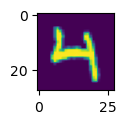

In [245]:
r = randint(0,60000)
sample_X, sample_y = train_X[r], train_y[r]
plt.figure(figsize=(1,1))
plt.imshow(sample_X.squeeze())
print(sample_y)
print(sample_X.shape)

In [246]:
BS = 32
train_dataloader = DataLoader(dataset=mnist_train, 
                              batch_size=BS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=mnist_test,
                             batch_size=BS,
                             shuffle=False)

In [247]:
sample_X.unsqueeze(dim=0).shape

torch.Size([1, 28, 28])

In [248]:
class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=32),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=32,out_features=10),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.layer_stack(x)
        x = self.classifier(x)
        return x

In [249]:
def get_accuracy(y_pred, y_true):
    return (y_pred==y_true).sum()

In [250]:
mymodel(sample_X.unsqueeze(dim=0)).argmax()

tensor(4)

In [273]:
n_epochs = 5

accuracies = []
losses = []

mymodel = model1()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=mymodel.parameters(), lr=0.1, momentum=0.0)

for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    if len(losses) > 0 and len(accuracies)>0: 
        print(f"Loss: {losses[len(losses)-1]}")
        print(f"Accuracy: {accuracies[len(accuracies)-1]}")
    
    epoch_loss = 0
    epoch_accuracy = 0
    
    for n_batch, (X, y) in enumerate(train_dataloader):
        
                
        optim.zero_grad()
        
        preds = mymodel(X)
        loss = criterion(preds, y)
        
        epoch_loss+=loss.item()
        
        loss.backward()
        
        optim.step()
        
        # get accuracy for this batch
        guesses = preds.argmax(dim=1)
        batch_accuracy = get_accuracy(guesses, y)
        epoch_accuracy += batch_accuracy
        
        if n_batch % 200 == 0:
            print(f"--- Batch {n_batch} / {60000/32}")
        
    losses.append(epoch_loss)
    print(f"    Accumulated Loss: {epoch_loss}")
    print(f"    Epoch Accuracy: {(epoch_accuracy/60000) * 100} %")      

Epoch: 1
--- Batch 0 / 1875.0
--- Batch 200 / 1875.0
--- Batch 400 / 1875.0
--- Batch 600 / 1875.0
--- Batch 800 / 1875.0
--- Batch 1000 / 1875.0
--- Batch 1200 / 1875.0
--- Batch 1400 / 1875.0
--- Batch 1600 / 1875.0
--- Batch 1800 / 1875.0
    Accumulated Loss: 710.8133945632726
    Epoch Accuracy: 88.62000274658203 %
Epoch: 2
--- Batch 0 / 1875.0
--- Batch 200 / 1875.0
--- Batch 400 / 1875.0
--- Batch 600 / 1875.0
--- Batch 800 / 1875.0
--- Batch 1000 / 1875.0
--- Batch 1200 / 1875.0
--- Batch 1400 / 1875.0
--- Batch 1600 / 1875.0
--- Batch 1800 / 1875.0
    Accumulated Loss: 274.101781190373
    Epoch Accuracy: 95.65833282470703 %
Epoch: 3
--- Batch 0 / 1875.0
--- Batch 200 / 1875.0
--- Batch 400 / 1875.0
--- Batch 600 / 1875.0
--- Batch 800 / 1875.0
--- Batch 1000 / 1875.0
--- Batch 1200 / 1875.0
--- Batch 1400 / 1875.0
--- Batch 1600 / 1875.0
--- Batch 1800 / 1875.0
    Accumulated Loss: 198.02734897797927
    Epoch Accuracy: 96.78666687011719 %
Epoch: 4
--- Batch 0 / 1875.0
--- 

In [274]:
with torch.inference_mode():
    mymodel.eval()
    
    accuracy_sum = 0
    
    
    for i, (X, y) in enumerate(test_dataloader):
        # this batch (size 32)
        
        preds = mymodel(X)
        
        accuracy = get_accuracy(preds.argmax(dim=1), y)
        
        accuracy_sum += accuracy
        

        
        
print(f"Accuracy: {accuracy_sum.detach().numpy() / len(test_X) * 100} %")        

Accuracy: 96.61999999999999 %


In [276]:
torch.save(mymodel.state_dict(), 'mymodel_weights.pth')

In [278]:
import onnx
import onnx_tf

dummy_input = torch.randn(32, 1, 28, 28)
torch.onnx.export(model, dummy_input, 'model.onnx', input_names=['input'], output_names=['output'])


ModuleNotFoundError: No module named 'onnx_tf'